In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()
    break


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/new/temp/textsum/model.seq2seq.attention'
predictor = melt.Predictor(model_dir)

def inference(text):
  predict(predictor, text)

ENCODE_UNK 1
restore from /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-3.2-269000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-3.2-269000


import graph ok /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-3.2-269000.meta
restore ok /home/gezi/new/temp/textsum/model.seq2seq.attention/model.ckpt-3.2-269000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5143, 5088, 7316, 532, 13, 691, 742, 805, 5143, 5088, 7316, 532, 13, 11810, 16506, 0, 0, 0, 0, 0] len: 20
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
0 [5088, 1] 辣椒/<EOS> 0.00887498373818 -4.72452 -4.72452 [-2.2239661, -2.5005527]


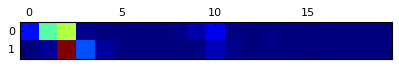

beam search using time(ms): 1154.00695801
word_ids [214, 899, 322, 1866, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球/吗
你/去/打/篮球/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0624883181053 -2.77278 -2.77278 [-0.80295438, -0.19650097, -1.7733203]


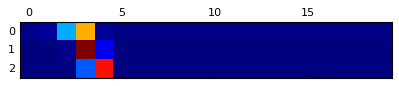

beam search using time(ms): 465.578079224
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0691334097225 -2.67172 -2.67172 [-0.69984692, -0.14536345, -1.8265069]


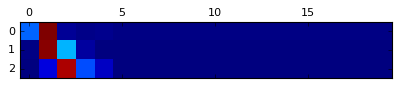

beam search using time(ms): 466.686010361
word_ids [1492, 210, 267, 244, 655, 8, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [20, 1] <UNK>/<EOS> 0.0136992545984 -4.29041 -4.29041 [-3.6892874, -0.60112625]


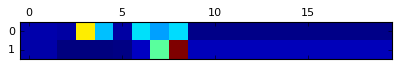

beam search using time(ms): 456.09498024
word_ids [25394, 84, 2743, 19, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [84, 1095, 1] 不/良/<EOS> 0.00138183631286 -6.58434 -6.58434 [-2.426187, -1.5480504, -2.6101046]


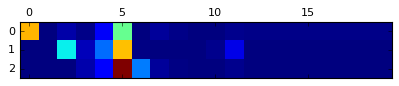

beam search using time(ms): 444.95511055
word_ids [60, 811, 2742, 235, 949, 3383, 60, 811, 2742, 2841, 1679, 57, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
0 [60, 811, 2742, 2841, 57, 1] 王/凯/整容/前后/照片/<EOS> 0.0314683607265 -3.45877 -3.45877 [-0.20960706, -0.54233831, -0.75034708, -0.67802447, -1.2256534, -0.052802365]


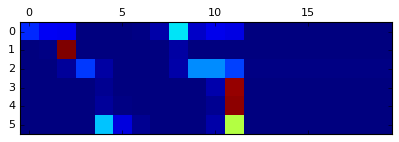

beam search using time(ms): 475.394010544
word_ids [6423, 1083, 5327, 226, 24332, 668, 668, 163, 13, 4073, 62, 107, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
0 [163, 62, 107, 1] 性感/黑/丝/<EOS> 0.0103528423379 -4.57049 -4.57049 [-2.3112919, -1.2887245, -0.016969364, -0.95350796]


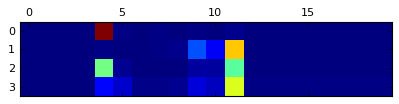

beam search using time(ms): 451.257944107
word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [20, 1] <UNK>/<EOS> 0.00779167724502 -4.8547 -4.8547 [-4.1601686, -0.69453061]


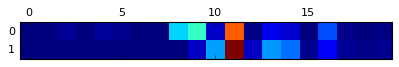

beam search using time(ms): 466.36390686
word_ids [37, 14356, 7, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 2255, 1] 美女/胸部/<EOS> 0.00150841190117 -6.4967 -6.4967 [-0.83508402, -4.2199135, -1.4417003]


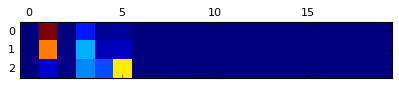

beam search using time(ms): 448.002815247
word_ids [1817, 7, 1252, 228, 7, 4006, 228, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
》/ /卫生/间/ /洗手/间/ 
》/ /卫生/间/ /洗手/间/ 
0 [1252, 228, 4006, 228, 1] 卫生/间/洗手/间/<EOS> 0.0455304228572 -3.08937 -3.08937 [-0.51347792, -0.0067421095, -0.71436095, -0.21624227, -1.6385512]


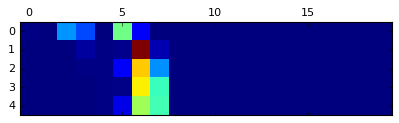

beam search using time(ms): 443.477153778
word_ids [2234, 7, 3885, 4193, 828, 146, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
iphone/ /6s/耐克/主题/手机/壁纸
iphone/ /6s/耐克/主题/手机/壁纸
0 [882, 146, 30, 1] 苹果/手机/壁纸/<EOS> 0.0311602821866 -3.46861 -3.46861 [-0.96068382, -0.97585237, -0.54029024, -0.99178457]


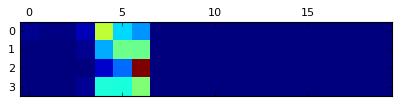

beam search using time(ms): 455.760002136


In [8]:
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
predict(predictor, '你去打篮球吗')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('年少不懂高晓松,读懂已不再少年')
inference('王凯整容了吗_王凯整容前后对比照片')
inference('【贴图】韩敏英--性感小吊带黑丝')
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看')
inference('美女劈叉 鼻血狂喷')
inference('》 卫生间 洗手间 ')
inference('iphone 6s耐克主题手机壁纸')

word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
0 [1298, 426, 1298, 426, 448, 1] 赵丽/颖/赵丽/颖/剧照/<EOS> 0.0351420212675 -3.34836 -3.34836 [-0.046753768, -0.015249332, -1.8490056, -0.040497579, -1.0520128, -0.34483874]


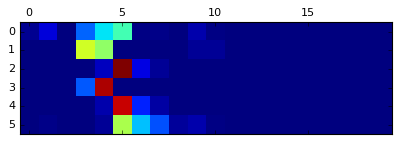

beam search using time(ms): 455.124855042


In [9]:
inference('蜀山战纪赵丽颖古装剧照(12张) ')

word_ids [323, 56, 758, 45, 301, 9147, 1733, 410, 570, 1100, 8, 6091, 1817, 0, 0, 0, 0, 0, 0, 0] len: 20
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
0 [323, 56, 45, 301, 1] 幼儿/园/简/笔画/<EOS> 0.0571987507526 -2.86122 -2.86122 [-0.96709204, -0.089718744, -0.4984265, -0.018713823, -1.2872722]


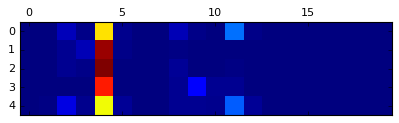

beam search using time(ms): 450.547218323


In [10]:
inference('幼儿园动物简笔画教案《两条漂亮的小鱼》')

word_ids [334, 595, 85, 1034, 11, 5593, 121, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
第/六/感/美甲/美/睫/纹/秀
第/六/感/美甲/美/睫/纹/秀
0 [1034, 1] 美甲/<EOS> 0.0299260038946 -3.50903 -3.50903 [-0.53945398, -2.9695735]


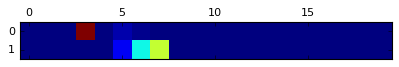

beam search using time(ms): 433.679103851


In [11]:
inference('第六感美甲美睫纹秀')

word_ids [4305, 5762, 3136, 5697, 2060, 389, 1961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
2013/春夏/男装/米兰/时装/秀/9
2013/春夏/男装/米兰/时装/秀/9
0 [2060, 389, 1] 时装/秀/<EOS> 0.070629682254 -2.6503 -2.6503 [-1.5796126, -0.053041834, -1.0176505]


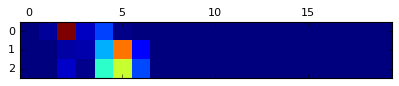

beam search using time(ms): 444.108009338


In [12]:
inference('2013春夏男装米兰时装秀9')

word_ids [772, 7630, 67, 89652, 8, 19841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
关于/房价/最/透彻/的/解读
关于/房价/最/透彻/的/解读
0 [7630, 1] 房价/<EOS> 0.00126630166553 -6.67165 -6.67165 [-4.2393522, -2.4323025]


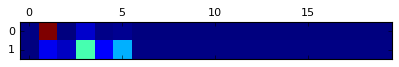

beam search using time(ms): 453.294992447


In [13]:
inference('关于房价最透彻的解读')

word_ids [4667, 630, 7902, 51, 1297, 10515, 4961, 7170, 16504, 3467, 25032, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
0 [10515, 1] 职称/<EOS> 0.000243904178058 -8.31874 -8.31874 [-4.7406383, -3.5780969]


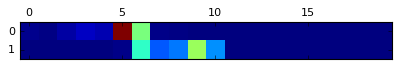

beam search using time(ms): 440.338850021


In [14]:
inference('辽宁省中小学教师职称制度改革实施方案出台')

word_ids [4470, 452, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
骷髅/情侣/纹身
骷髅/情侣/纹身
0 [208, 1475, 1] 纹身/手稿/<EOS> 0.00490323247135 -5.31786 -5.31786 [-2.1968946, -2.213681, -0.90728492]


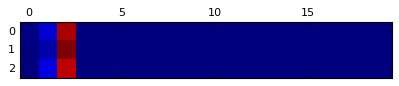

beam search using time(ms): 459.692955017


In [15]:
inference('骷髅情侣纹身')

word_ids [42999, 869, 1474, 363, 8, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0215286626592 -3.83837 -3.83837 [-1.2257527, -0.28457791, -0.55769569, -1.7703438]


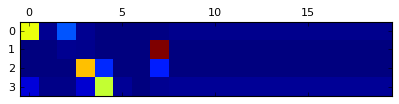

beam search using time(ms): 442.102909088


In [16]:
inference('酷似朴姬兰的刘亦菲')

word_ids [42999, 164, 926, 649, 8, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0332942538853 -3.40237 -3.40237 [-0.98913997, -0.23184137, -0.59330601, -1.588083]


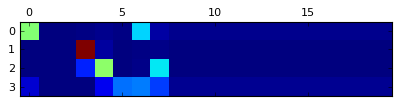

beam search using time(ms): 446.912050247


In [17]:
inference('酷似刘亦菲的朴姬兰')

word_ids [97, 80, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
我/爱/打/篮球
我/爱/打/篮球
0 [1866, 1866, 1] 篮球/篮球/<EOS> 0.0127712649667 -4.36056 -4.36056 [-1.3996754, -1.7195632, -1.2413192]


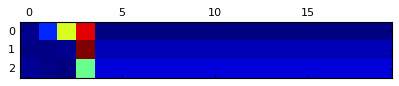

beam search using time(ms): 423.221826553


In [18]:
inference('我爱打篮球')

word_ids [322, 1866, 181, 84, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/好/不/好
打/篮球/好/不/好
0 [322, 1866, 6, 1] 打/篮球/图片/<EOS> 0.0636531746879 -2.75431 -2.75431 [-0.68879592, -0.16450171, -1.5738821, -0.32712635]


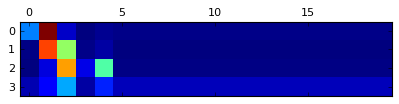

beam search using time(ms): 448.605060577


In [19]:
inference('打篮球好不好')

word_ids [1236, 682, 4349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
帅哥/戴/墨镜
帅哥/戴/墨镜
0 [1236, 682, 4349, 1] 帅哥/戴/墨镜/<EOS> 0.0782290435276 -2.54811 -2.54811 [-0.73123276, -0.72477806, -0.16147496, -0.93062854]


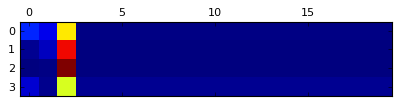

beam search using time(ms): 470.314025879


In [20]:
inference('帅哥戴墨镜')

word_ids [27135, 7, 1614, 6577, 8, 157, 10898, 21077, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
0 [20, 1] <UNK>/<EOS> 0.0167295836837 -4.09058 -4.09058 [-3.7887199, -0.3018567]


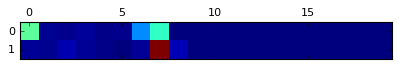

beam search using time(ms): 441.309213638


In [21]:
inference('厄瓜多尔 美丽神秘的南美洲国度 ')